In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd
from scipy.stats import linregress, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import plot


simplefilter(action='ignore', category=FutureWarning)


# Set input files
DGE_FILE = '../data/dge/dge.txt'
SITES_FILE = '../results/site_predictions/sites.txt'

# Set directory for saving plots
FIG_DIR = '../results/graphs/FIG2/'

# Set color palettes for plots
VOLCANO_PALETTE = ['#000092', '#e60000', '#a23582']
DIST_PALETTE = ['#000000', '#023eff', '#00d7ff', '#f14cc1', '#e8000b']

## FIG. 2A

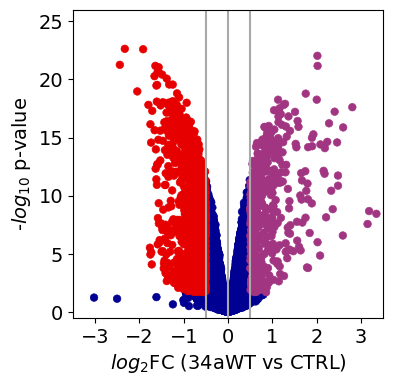

  Diff exp WT-NC  count
0           None  12085
1           Down   1146
2             Up    509 



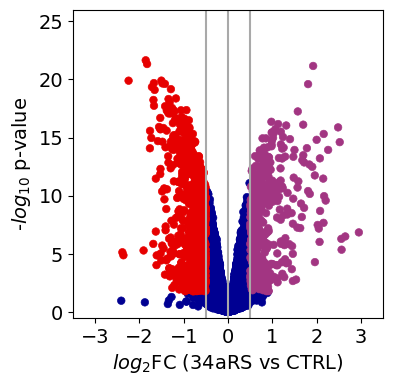

  Diff exp RS-NC  count
0           None  12330
1           Down    943
2             Up    467 



<Figure size 400x400 with 0 Axes>

In [2]:
# Read data: all genes
data = pd.read_csv(DGE_FILE, sep='\t')

contrasts = ['WT-NC', 'RS-NC']
groups = ['None', 'Down', 'Up']
xlabels = {'WT-NC': '$log_{2}$FC (34aWT vs CTRL)',
           'RS-NC': '$log_{2}$FC (34aRS vs CTRL)'}

for contrast in contrasts:
    x_var = 'log2fc '+contrast
    y_var = '-log10 pval '+contrast
    hue = 'Diff exp '+contrast

    data[y_var] = -np.log10(data['pval '+contrast])
    data[hue] = data.apply(
        lambda x: 'Up' if x['FDR '+contrast] < 0.05 and x[x_var] > 0.5
        else 'Down' if x['FDR '+contrast] < 0.05 and x[x_var] < -0.5
        else 'None', axis=1)

    plot.scatter(
        data, x=x_var, y=y_var, hue=hue, hue_order=groups,
        palette=VOLCANO_PALETTE, size=30, xlim=(-3.5, 3.5), ylim=(-0.5, 26),
        xticks=(-3, 3, 1), yticks=(0, 25, 5), vlines=(-0.5, 0, 0.5),
        xlabel=xlabels[contrast], ylabel='-$log_{10}$ p-value',
        outfile=FIG_DIR+'2A_'+contrast)

    counts = data[hue].value_counts().reset_index()
    counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
    print(counts, '\n')

## FIG. 2B

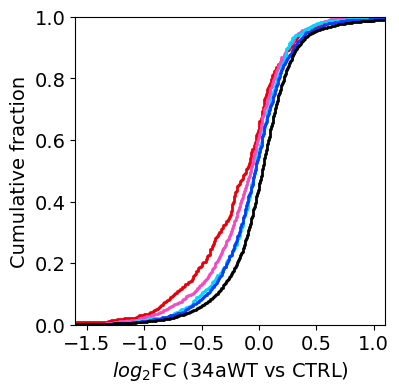

WT-NC: p = 2.3e-53 (ANOVA)



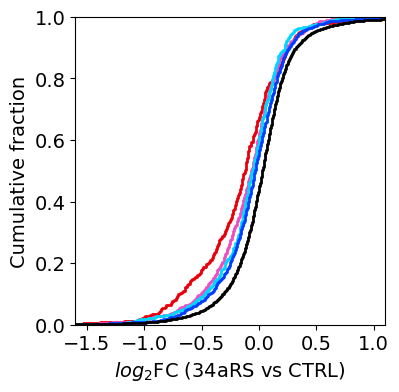

RS-NC: p = 3.9e-65 (ANOVA)

  Site type  count
0   No site   8613
1      6mer   1387
3   7mer-a1    598
2   7mer-m8    905
4      8mer    397 



<Figure size 400x400 with 0 Axes>

In [3]:
# Read data: genes with =1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites[['Gene ID', 'Site type']], how='outer')
data['Site type'] = data['Site type'].fillna('No site')
# Drop genes with more than one site
data.drop_duplicates(subset='Gene ID', keep=False, inplace=True)

contrasts = ['WT-NC', 'RS-NC']
hue = 'Site type'
groups = ['No site', '6mer', '7mer-a1', '7mer-m8', '8mer']
xlabels = {'WT-NC': '$log_{2}$FC (34aWT vs CTRL)',
           'RS-NC': '$log_{2}$FC (34aRS vs CTRL)'}

for contrast in contrasts:
    x_var = 'log2fc '+contrast

    plot.cumulative_hist(
        data, x=x_var, hue=hue, hue_order=groups, palette=DIST_PALETTE,
        xlim=(-1.6, 1.1), xticks=(-1.5, 1, 0.5), xlabel=xlabels[contrast], legend=False,
        outfile=FIG_DIR+'2B_'+contrast)

    model = f_oneway(*[data[data[hue] == group][x_var] for group in groups])
    print(contrast+': p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')

## FIG. 2C

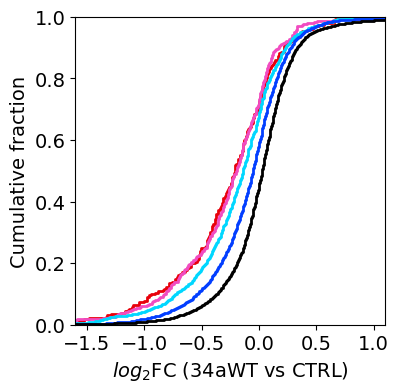

WT-NC: p = 1.2e-148 (ANOVA)



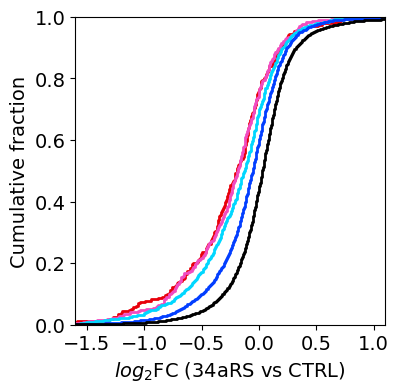

RS-NC: p = 6e-177 (ANOVA)

  Site count  count
0          0   8613
1          1   3287
2          2   1160
3          3    450
4        >=4    230 



<Figure size 400x400 with 0 Axes>

In [4]:
# Read data: all genes
data = pd.read_csv(DGE_FILE, sep='\t')
# Count the number of sites per Gene ID
sites = pd.read_csv(SITES_FILE, sep='\t')
site_counts = sites['Gene ID'].value_counts(sort=True).reset_index()
site_counts.columns = ['Gene ID', 'Site count']
site_counts['Site count'] = site_counts['Site count'].apply(
    lambda x: '>=4' if x >= 4 else str(x))
# Merge with DGE data and set site count 0 for genes without sites
data = pd.merge(data, site_counts, how='outer')
data['Site count'] = data['Site count'].fillna('0')

contrasts = ['WT-NC', 'RS-NC']
hue = 'Site count'
groups = ['0', '1', '2', '3', '>=4']
xlabels = {'WT-NC': '$log_{2}$FC (34aWT vs CTRL)',
           'RS-NC': '$log_{2}$FC (34aRS vs CTRL)'}

for contrast in contrasts:
    x_var = 'log2fc '+contrast

    plot.cumulative_hist(
        data, x=x_var, hue=hue, hue_order=groups, palette=DIST_PALETTE,
        xlim=(-1.6, 1.1), xticks=(-1.5, 1, 0.5), xlabel=xlabels[contrast],
        outfile=FIG_DIR+'2C_'+contrast)

    model = f_oneway(*[data[data[hue] == i][x_var] for i in groups])
    print(contrast+': p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')